# Imports

In [1]:
# Imports
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.rcParams["axes.grid"] = False #disable ugly white lines which are present in google colab for matplotlib
import numpy as np
import datetime
today = datetime.datetime.today() #To work with datetime values. Only relative time matters in this project, so selecting a random date is not a problem. 
from sklearn.metrics import classification_report,auc,r2_score,matthews_corrcoef
import shap
from catboost import CatBoostClassifier,CatBoostRegressor,Pool
from catboost.utils import get_roc_curve
import pandas as pd
import re
import os
from scipy.stats import linregress,ttest_ind,ranksums
uzgent_data_path = "../data/uzgent/"
amsterdam_data_path = "../data/amsterdam/"
from tabulate import tabulate
from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
present = False
if present:
    params = {"ytick.color" : "w",
            "xtick.color" : "w",
            "axes.titlecolor" : "w",
            "axes.labelcolor" : "w",
            "axes.edgecolor" : "w"}
    plt.rcParams.update(params)
    plt.rcParams.update({'font.size': 18})
else:
    params = {"ytick.color" : "black",
            "xtick.color" : "black",
            "axes.titlecolor" : "black",
            "axes.labelcolor" : "black",
            "axes.edgecolor" : "black"}
    plt.rcParams.update(params)

# External Validation

## Function declarations

In [4]:
def ece_calculator(X,y,model,plot_bool=False):
    confidences = np.max(model.predict_proba(X),axis=1)
    output_t = np.argmax(model.predict_proba(X),axis=1)

    max_bin = 5

    ECE_arr = np.array([])
    cal_plot_ECE = list([])
    ESCE_arr = np.array([])
    for i in np.arange(0.5,max_bin + 0.1,0.1):
        bins_size = i
        bin_epsilon = 0.00001
        bin_min = np.round(np.min(confidences*100))

        pred_out = output_t
        real_out = y.values
        bins_correct = plt.hist(confidences[np.where(pred_out==real_out)]*100,density=False,label="Correct pred",bins=np.arange(bin_min,101.0,bins_size),ec='black')
        bins_incorrect = plt.hist(confidences[np.where(pred_out!=real_out)]*100,density=False,label="Incorrect pred",bins=np.arange(bin_min,101.0,bins_size),ec='black')
        

        bin_means = np.array([])
        for b in np.arange(bin_min,101.0,bins_size):
            bin_means = np.append(bin_means,np.array(np.mean(np.append([bin_epsilon],confidences[np.where((confidences > b/100.0)&(confidences <= (b/100.0+bins_size/100.0)))]))))

        bin_means = bin_means[:-1]

        #avg accuracy per bin - avg confidence per bin (summed over all bins and normalized by width of size of bin)
        ECE = np.sum((bins_correct[0]+bins_incorrect[0])/len(confidences) * (np.abs(bins_correct[0]/(bins_correct[0]+bins_incorrect[0]+bin_epsilon) - bin_means)))
        cal_plot_ECE.append(np.array((bins_correct[0]/(bins_correct[0]+bins_incorrect[0]+bin_epsilon))))
        ESCE = np.sum((bins_correct[0]+bins_incorrect[0])/len(confidences) * (bins_correct[0]/(bins_correct[0]+bins_incorrect[0]+bin_epsilon) - bin_means))
        ECE_arr = np.append(ECE_arr,np.array(ECE))
        ESCE_arr = np.append(ESCE_arr,np.array(ESCE))

    plt.clf()

    if plot_bool:
        plt.figure(figsize=(12,8))
        plt.plot(np.arange(0.5,max_bin + 0.1,0.1),ECE_arr*100,label="avg ECE")
        plt.plot(np.arange(0.5,max_bin + 0.1,0.1),ESCE_arr*100,label="avg ESCE")

        plt.legend()
        plt.xlabel("Bin size ")
        plt.ylabel("ECE (% error)")
        plt.show()

        plt.figure(figsize=(12,8))

        bin_min = np.round(np.min(confidences*100))

        mean_sece = np.array([])
        increment_perc = 1
        for perc in np.arange(bin_min+increment_perc,100+increment_perc,increment_perc):
            mean_array = np.array([])
            idx = 0
            for calplots in cal_plot_ECE:
                bins_size = np.arange(0.5,max_bin + 0.1,0.1)[idx]
                plot_arr = np.where(calplots!=0)

                x_ar = (np.arange(bin_min,101.0,bins_size)[:-1]+bins_size/2)[plot_arr]
                cal_plot_mean = calplots[plot_arr][np.where((x_ar < perc) & (x_ar >= perc-increment_perc))]
                
                if len(cal_plot_mean>0):
                    temp_mean = np.mean(cal_plot_mean)
                    mean_array = np.append(mean_array,temp_mean)
                
                idx += 1

            mean_sece = np.append(mean_sece,np.mean(mean_array))


        for i in range(len(cal_plot_ECE)):
            bins_size = np.arange(0.5,max_bin + 0.1,0.1)[i]
            x_ar = np.arange(bin_min,101.0,bins_size)[:-1]+bins_size/2
            plot_arr = np.where(cal_plot_ECE[i]!=0)
            plt.plot(x_ar[plot_arr],cal_plot_ECE[i][plot_arr]*100,alpha=0.2,color="blue")
        plt.plot(np.arange(bin_min+increment_perc/2,100+increment_perc/2,increment_perc),mean_sece*100,color="red",label="average")
        plt.plot([50,100],[50,100],color="black",label="Perfect calibration")
        plt.xlim([50,100])
        plt.ylim([0,100])
        plt.xticks(np.arange(50,104,5))
        plt.xlabel("Predicted probabilities (%)")
        plt.ylabel("Observed probabilities (%)")
        plt.grid()
        plt.legend()
        plt.show()

    print("ECE normalized AUC (%) = "+str(np.round(np.mean(ECE_arr)*100,2))+" %")
    print("ESCE normalized AUC (%) = "+str(np.round(np.mean(ESCE_arr)*100,2))+" %")

    return np.mean(ECE_arr),np.mean(ESCE_arr)

def pandas_result_AF_maker(patient_group_string,X,y,model,append_df):
    (fpr, tpr, thresholds) = get_roc_curve(model, Pool(data=X,label=y), plot=False)
    res_dict = classification_report(y,model.predict(X),target_names=["No-AF","AF"],output_dict=True)

    ECE,ESCE = ece_calculator(X,y,model)

    append_df = pd.concat([append_df,pd.DataFrame(data=[[model_string,validation_type_string,patient_group_string,
                    res_dict["No-AF"]["support"],res_dict["AF"]["support"],
                    res_dict["No-AF"]["recall"],res_dict["AF"]["recall"],
                    res_dict["No-AF"]["precision"],res_dict["AF"]["precision"],
                    res_dict["No-AF"]["f1-score"],res_dict["AF"]["f1-score"],
                    matthews_corrcoef(y,model.predict(X)),auc(fpr,tpr),ECE,ESCE
                   ]],columns=uzgent_result_dataframe_columns)])
    
    return append_df


uzgent_result_dataframe_columns=["model","validation_type","patient_group","NO AF patients","AF patients","NO AF recall","AF recall","NO AF precision","AF precision","NO AF f1","AF f1","mcc","auc","ECE","ESCE"]
# uzgent_result_dataframe = pd.DataFrame(columns=uzgent_result_dataframe_columns)

uzgent_p_value_result_dataframe_columns=["model","comparison","AF_group","p_value"]
# uzgent_p_value_result_dataframe = pd.DataFrame(columns=uzgent_p_value_result_dataframe_columns)

# missing_dataframe = pd.DataFrame(columns=["model","feature","train amst","balanced test amst","all test amst","train uzgent","balanced test uzgent","all test uzgent"])

In [5]:
#uzgent_result_dataframe.reset_index(drop=True).to_csv("../results/uzgent_af_prediction_results.csv")

In [24]:
#True
#False

one_half_hour_model = False
six_hour_model = True

model_string = ("1.5"*int(one_half_hour_model)+"12"*int(1-one_half_hour_model))*int(1-six_hour_model)+"6"*int(six_hour_model)
print(model_string)

6


## Transfer validation

In [25]:
validation_type_string = "transfer"

### Data import

In [26]:
if one_half_hour_model:
    AF_dataset = pd.read_csv(uzgent_data_path+"AF_dataset_1_5_hours.csv") 
elif six_hour_model:
    AF_dataset = pd.read_csv(uzgent_data_path+"AF_dataset_6_hours.csv") 
else:
    AF_dataset = pd.read_csv(uzgent_data_path+"AF_dataset_12_hours.csv") 

        
AF_dataset = AF_dataset.rename(columns={"HospAdmissionID":"patientid","AgeOnAdmission":"Age","ICUSessionID":"admissionid"})
AF_dataset.loc[AF_dataset.sepsis_extra_opn_measuredat > AF_dataset.AF_measuredat,"sepsis_bool_extra_opn"]=0

AF_dataset.loc[(~AF_dataset.bmi.isna())&(AF_dataset.bmi.str.contains(",")),'bmi']=np.NaN

Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.


In [27]:
AF_dataset["is_given_NORepinefrine"]=0
AF_dataset.loc[AF_dataset['mean_CV_norepinephrine']>0,"is_given_NORepinefrine"]=1


AF_dataset["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
AF_dataset.loc[(AF_dataset["mean_VI_calcium carbonate"]>1)|(AF_dataset["mean_VI_calcium chloride"]>1),"is_given_Calcium Glubionaat (Calcium Sandoz)"] = 1
    
AF_dataset["is_given_Dopamine (Inotropin)"]=0
AF_dataset.loc[AF_dataset['mean_CV_dopamine']>0,"is_given_Dopamine (Inotropin)"]=1

AF_dataset['is_given_Propofol (Diprivan)']=0
AF_dataset.loc[AF_dataset['mean_NS_propofol']>0,'is_given_Propofol (Diprivan)']=1

AF_dataset['is_given_Fentanyl']=0
AF_dataset.loc[AF_dataset['mean_NS_fentanyl']>0,'is_given_Fentanyl']=1

AF_dataset["is_given_Furosemide (Lasix)"]=0
AF_dataset.loc[AF_dataset['mean_DI_furosemide']>0,"is_given_Furosemide (Lasix)"]=1

AF_dataset["is_given_LoopDiuretics"]=0
AF_dataset.loc[(AF_dataset['mean_DI_furosemide']>0),"is_given_LoopDiuretics"]=1

AF_dataset["sepsis_bool"]=0
AF_dataset.loc[(AF_dataset.sepsis_bool_comorb_source==1) | (AF_dataset.sepsis_bool_extra_opn==1),"sepsis_bool"]=1

AF_dataset.loc[AF_dataset['mean_PEEP_M_ALL'].isna(),"mean_PEEP_M_ALL"]=0

AF_dataset.loc[AF_dataset.icuurg=="Urgent","icuurg"]=1
AF_dataset.loc[AF_dataset.icuurg!=1,"icuurg"]=0


In [28]:
#Rename for distr change 12 hour model
AF_dataset = AF_dataset.rename(columns={'mean_PEEP_M_ALL':'mean_PEEP (Set)', 'is_given_NORepinefrine':'is_given_Noradrenaline (Norepinefrine)', 'mean_URINE_VOL':'mean_UrineCAD', 
                            'max_PEEP_M_ALL':'max_PEEP (Set)','min_PEEP_M_ALL':'min_PEEP (Set)',
                            'max_PHOSPHATE_ALL':'max_Fosfaat (bloed)','min_HR_ALL':'min_Hartfrequentie','mean_HR_ALL':'mean_Hartfrequentie','slope_HR_ALL':'slope_Hartfrequentie',
                            'min_PH_ART_ALL':'min_pH (bloed)','mean_PH_ART_ALL':'mean_pH (bloed)','max_PH_ART_ALL':'max_pH (bloed)',
                            'mean_LACTATE_ART':'mean_Lactaat (bloed)','max_LACTATE_ART':'max_Lactaat (bloed)' ,'min_LACTATE_ART':'min_Lactaat (bloed)' , 
                            'min_URINE_VOL':'min_UrineCAD', 'max_URINE_VOL':'max_UrineCAD', 'slope_URINE_VOL':'slope_UrineCAD', 'icuurg':'urgency',
                            'mean_BALANS-Tot.':'fluid_balance', 'slope_RESPRATE_ALL':'slope_O2 l/min','Length':'Height',
                            'mean_HCO3_ART':'mean_Act.HCO3 (bloed)','max_HCO3_ART':'max_Act.HCO3 (bloed)','min_HCO3_ART':'min_Act.HCO3 (bloed)','slope_HCO3_ART':'slope_Act.HCO3 (bloed)',
                            'mean_PO2_ART':'mean_PO2 (bloed)','min_PO2_ART':'min_PO2 (bloed)','max_PO2_ART':'max_PO2 (bloed)','slope_PO2_ART':'slope_PO2 (bloed)',
                            'mean_BE_ART':'mean_B.E. (bloed)','min_BE_ART':'min_B.E. (bloed)','max_BE_ART':'max_B.E. (bloed)','slope_BE_ART':'slope_B.E. (bloed)',
                            'mean_PCO2_ART':'mean_pCO2 (bloed)','min_PCO2_ART':'min_pCO2 (bloed)','max_PCO2_ART':'max_pCO2 (bloed)','slope_PCO2_ART':'slope_pCO2 (bloed)',
                            'mean_IBP_M':'mean_ABP gemiddeld','min_IBP_M':'min_ABP gemiddeld','max_IBP_M':'max_ABP gemiddeld','slope_IBP_M':'slope_ABP gemiddeld',
                            'mean_IBP_S':'mean_ABP systolisch','min_IBP_S':'min_ABP systolisch','max_IBP_S':'max_ABP systolisch','slope_IBP_S':'slope_ABP systolisch',
                            'mean_FIO2_MV_ALL':'mean_O2 concentratie (Set)','max_FIO2_MV_ALL':'max_O2 concentratie (Set)','min_FIO2_MV_ALL':'min_O2 concentratie (Set)',
                            'mean_O2SAT_ART':'mean_O2-Saturatie (bloed)','max_O2SAT_ART':'max_O2-Saturatie (bloed)','min_O2SAT_ART':'min_O2-Saturatie (bloed)',
                           'min_NS_propofol':'min_Propofol (Diprivan)', 'min_NS_fentanyl':'min_Fentanyl', 'mean_RESPRATE_ALL':'mean_O2 l/min', 
                           'mean_PHOSPHATE_ALL':'mean_Fosfaat (bloed)', 'kurt_CVD':'kurt_CVD', 'max_HR_ALL':'max_Hartfrequentie', "max_PLATELETS":"max_Thrombo's (bloed)"})

#Rename for distr change 6 hour model
AF_dataset = AF_dataset.rename(columns={'max_RESPRATE_ALL':'max_O2 l/min',
                                        'min_PHOSPHATE_ALL':'min_Fosfaat (bloed)', 'mean_CVD':'mean_CVD', 
                                        "min_PLATELETS":"min_Thrombo's (bloed)","slope_PLATELETS":"slope_Thrombo's (bloed)"})

#Rename for distr change 1.5 hour model
AF_dataset = AF_dataset.rename(columns={'max_UREA_ALL':'max_Ureum (bloed)','mean_UREA_ALL':'mean_Ureum (bloed)','min_UREA_ALL':'min_Ureum (bloed)'})

#Rename for standard 12 hour model
AF_dataset = AF_dataset.rename(columns={"slope_PO2_ART":'slope_PO2 (bloed)'})

#Rename for standard 1.5 hour model
AF_dataset = AF_dataset.rename(columns={ 'min_RESPRATE_ALL':'min_O2 l/min', "mean_PLATELETS":"mean_Thrombo's (bloed)",
                                        'min_CVD':'min_CVD'})

In [29]:
AF_1_df = AF_dataset[AF_dataset.AF==1]
AF_0_matched_df = AF_dataset[(AF_dataset.AF==0)&(AF_dataset.admissionid!=AF_dataset.date_corresponds_to_AF_admid)]

train_admissionid,test_admissionid = train_test_split(AF_1_df.admissionid.unique(), test_size=0.2, random_state=42)

train_AF_1_dataset = AF_1_df[AF_1_df.admissionid.isin(train_admissionid)]
test_AF_1_dataset = AF_1_df[AF_1_df.admissionid.isin(test_admissionid)]

train_AF_0_dataset = AF_0_matched_df[AF_0_matched_df.date_corresponds_to_AF_admid.isin(train_AF_1_dataset.admissionid)]
test_AF_0_dataset = AF_0_matched_df[AF_0_matched_df.date_corresponds_to_AF_admid.isin(test_AF_1_dataset.admissionid)]

train_AF_dataset = train_AF_0_dataset.append(train_AF_1_dataset).reset_index(drop=True).sample(len(train_AF_0_dataset)+len(train_AF_1_dataset),random_state=42)
test_AF_dataset = test_AF_0_dataset.append(test_AF_1_dataset).reset_index(drop=True).sample(len(test_AF_0_dataset)+len(test_AF_1_dataset),random_state=42)

In [30]:
X_train_or = train_AF_dataset
X_test_or = test_AF_dataset
y_train = train_AF_dataset.AF
y_test = test_AF_dataset.AF

### Testing

In [31]:
if one_half_hour_model:

    feature_columns = ['Age', 
        'is_given_Noradrenaline (Norepinefrine)', 
        'max_Hartfrequentie',
       'mean_PEEP (Set)', 
       'mean_CVD', 
       'mean_O2 concentratie (Set)',
       "min_Thrombo's (bloed)",
       'urgency', 
       'mean_UrineCAD', 
       'is_given_Furosemide (Lasix)', 
       'mean_Ureum (bloed)',
       'slope_B.E. (bloed)',
       'slope_ABP systolisch', 
       'mean_O2-Saturatie (bloed)', 
       'fluid_balance']

elif six_hour_model:

    feature_columns = ['Age', 
        'is_given_Noradrenaline (Norepinefrine)',
        'max_Hartfrequentie', 
        'mean_PEEP (Set)',
        'min_CVD',
        'mean_O2 concentratie (Set)', 
        'urgency', 
        'mean_UrineCAD',
        'is_given_Furosemide (Lasix)', 
        'fluid_balance', 
        'slope_ABP gemiddeld',
        'mean_O2-Saturatie (bloed)', 
        'max_Fosfaat (bloed)',
        'max_ABP systolisch',
        'min_Lactaat (bloed)'
    ]

else:

    feature_columns = ['Age',
        'mean_CVD',
        'mean_O2 concentratie (Set)',
        'mean_PEEP (Set)',
        'is_given_Noradrenaline (Norepinefrine)',
        'min_pH (bloed)',
        'max_UrineCAD',
        'mean_Hartfrequentie',
        'urgency',
        'min_Fosfaat (bloed)',
        'is_given_Furosemide (Lasix)',
        'is_given_Propofol (Diprivan)',
        'mean_O2-Saturatie (bloed)',
        "max_Thrombo's (bloed)",
        'max_ABP systolisch'
    ]

X_train=X_train_or[feature_columns]    
X_test= X_test_or[feature_columns] 

In [134]:
AF_class_balance = [y_train.sum()/len(y_train),1-y_train.sum()/len(y_train)]


if one_half_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, l2_leaf_reg=3, depth=3, class_weights=AF_class_balance)
elif six_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=400, depth=3, l2_leaf_reg=3, class_weights=AF_class_balance)
else:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, depth=3, l2_leaf_reg=3, class_weights=AF_class_balance)


CB_AF.fit(X_train,y_train)

0:	learn: 0.6833561	total: 1.27ms	remaining: 381ms
100:	learn: 0.4760895	total: 96.2ms	remaining: 189ms
200:	learn: 0.4372438	total: 176ms	remaining: 86.8ms
299:	learn: 0.4069179	total: 257ms	remaining: 0us


In [135]:
print(classification_report(y_train,CB_AF.predict(X_train),target_names=["No-AF","AF"]))

              precision    recall  f1-score   support

       No-AF       0.84      0.82      0.83       630
          AF       0.82      0.85      0.84       630

    accuracy                           0.83      1260
   macro avg       0.83      0.83      0.83      1260
weighted avg       0.83      0.83      0.83      1260



In [136]:
print("BALANCED TEST PATIENTS")
print(classification_report(y_test,CB_AF.predict(X_test),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_AF.predict(X_test)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("balanced test",X_test,y_test,CB_AF,uzgent_result_dataframe)

BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.76      0.71      0.73       157
          AF       0.73      0.77      0.75       158

    accuracy                           0.74       315
   macro avg       0.74      0.74      0.74       315
weighted avg       0.74      0.74      0.74       315



AUC = 0.8182
MCC = 0.4864
ECE normalized AUC (%) = 10.52 %
ESCE normalized AUC (%) = 5.19 %


<Figure size 432x288 with 0 Axes>

In [137]:
transfer_y_test = y_test
transfer_predict = CB_AF.predict(X_test)

In [138]:
temp_large_db = AF_dataset[((AF_dataset.AF==0)&(~AF_dataset.admissionid.isin(AF_0_matched_df.admissionid)))|(AF_dataset.admissionid.isin(test_AF_dataset.admissionid))]

y_test_all_pat = temp_large_db.AF
X_test_all_pat = temp_large_db[feature_columns]

print("ALL PATIENTS")
print(classification_report(y_test_all_pat,CB_AF.predict(X_test_all_pat),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_all_pat,label=y_test_all_pat), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_all_pat,CB_AF.predict(X_test_all_pat)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("all patients",X_test_all_pat,y_test_all_pat,CB_AF,uzgent_result_dataframe)

print("BALANCED TEST PATIENTS")
print(classification_report(y_test,CB_AF.predict(X_test),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_AF.predict(X_test)),4)))
print(50*"=")

ALL PATIENTS
              precision    recall  f1-score   support

       No-AF       1.00      0.74      0.85      9835
          AF       0.05      0.77      0.09       158

    accuracy                           0.74      9993
   macro avg       0.52      0.76      0.47      9993
weighted avg       0.98      0.74      0.84      9993



AUC = 0.8292
MCC = 0.1458
ECE normalized AUC (%) = 3.2 %
ESCE normalized AUC (%) = -1.92 %
BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.76      0.71      0.73       157
          AF       0.73      0.77      0.75       158

    accuracy                           0.74       315
   macro avg       0.74      0.74      0.74       315
weighted avg       0.74      0.74      0.74       315



AUC = 0.8182
MCC = 0.4864


<Figure size 432x288 with 0 Axes>

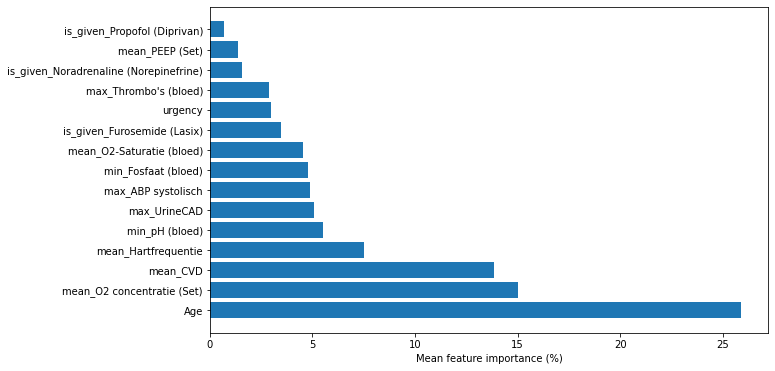

In [139]:
present=False

am_show_features = 60 if len(X_train.columns)>=30 else len(X_train.columns)
fi = CB_AF.feature_importances_
plt.figure(figsize=(10,6))
indices_T0 = np.argsort(fi)[::-1][0:am_show_features]
if present:
    plt.barh(range(am_show_features),fi[indices_T0],color="#e898ac")
else:
    plt.barh(range(am_show_features),fi[indices_T0])
plt.yticks(range(am_show_features), X_train.columns[indices_T0])
plt.xlabel("Mean feature importance (%)")
if present:
    ax = plt.gca()
    ax.patch.set_alpha(0)
#plt.tight_layout()
plt.show()

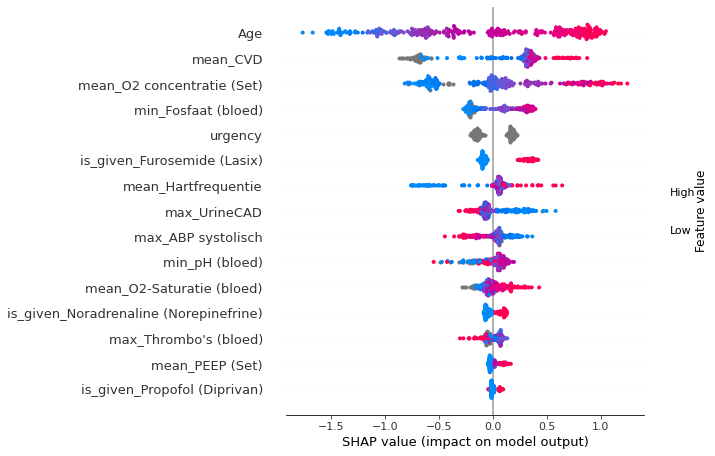

In [140]:
present=False

explainer = shap.TreeExplainer(CB_AF)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test,show=False)


## Combo validation 

In [141]:
validation_type_string = "combo"

### Data Import

In [142]:
if one_half_hour_model:
        AF_dataset_uzgent = pd.read_csv(uzgent_data_path+"AF_dataset_1_5_hours.csv") 
        AF_dataset = pd.read_csv(amsterdam_data_path+"AF_dataset_1_5_hours.csv") 
elif six_hour_model:
        AF_dataset_uzgent = pd.read_csv(uzgent_data_path+"AF_dataset_6_hours.csv") 
        AF_dataset = pd.read_csv(amsterdam_data_path+"AF_dataset_6_hours.csv") 
else:
        AF_dataset_uzgent = pd.read_csv(uzgent_data_path+"AF_dataset_12_hours.csv") 
        AF_dataset = pd.read_csv(amsterdam_data_path+"AF_dataset_12_hours.csv") 
        
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={"HospAdmissionID":"patientid","AgeOnAdmission":"Age","ICUSessionID":"admissionid"})
AF_dataset_uzgent.loc[AF_dataset_uzgent.sepsis_extra_opn_measuredat > AF_dataset_uzgent.AF_measuredat,"sepsis_bool_extra_opn"]=0

Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.


In [143]:
AF_dataset_uzgent["is_given_NORepinefrine"]=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_CV_norepinephrine']>0,"is_given_NORepinefrine"]=1

AF_dataset_uzgent["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
AF_dataset_uzgent.loc[(AF_dataset_uzgent["mean_VI_calcium carbonate"]>1)|(AF_dataset_uzgent["mean_VI_calcium chloride"]>1),"is_given_Calcium Glubionaat (Calcium Sandoz)"] = 1
    
AF_dataset_uzgent["is_given_Dopamine (Inotropin)"]=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_CV_dopamine']>0,"is_given_Dopamine (Inotropin)"]=1

AF_dataset_uzgent['is_given_Propofol (Diprivan)']=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_NS_propofol']>0,'is_given_Propofol (Diprivan)']=1

AF_dataset_uzgent['is_given_Fentanyl']=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_NS_fentanyl']>0,'is_given_Fentanyl']=1

AF_dataset_uzgent["is_given_Furosemide (Lasix)"]=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_DI_furosemide']>0,"is_given_Furosemide (Lasix)"]=1

AF_dataset_uzgent["is_given_LoopDiuretics"]=0
AF_dataset_uzgent.loc[(AF_dataset_uzgent['mean_DI_furosemide']>0),"is_given_LoopDiuretics"]=1

AF_dataset_uzgent["sepsis_bool"]=0
AF_dataset_uzgent.loc[(AF_dataset_uzgent.sepsis_bool_comorb_source==1) | (AF_dataset_uzgent.sepsis_bool_extra_opn==1),"sepsis_bool"]=1

AF_dataset_uzgent.loc[AF_dataset_uzgent.icuurg=="URGENT","icuurg"]=1
AF_dataset_uzgent.loc[AF_dataset_uzgent.icuurg!=1,"icuurg"]=0


In [144]:
AF_dataset["is_given_Magnesiumsulfaat (MgSO4)"]=0
AF_dataset.loc[AF_dataset['mean_Magnesiumsulfaat (MgSO4)']>0,"is_given_Magnesiumsulfaat (MgSO4)"]=1

AF_dataset["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
AF_dataset.loc[AF_dataset['mean_Calcium Glubionaat (Calcium Sandoz)']>0,"is_given_Calcium Glubionaat (Calcium Sandoz)"]=1

AF_dataset["is_given_LoopDiuretics"]=0
AF_dataset.loc[ (AF_dataset['mean_Furosemide (Lasix)']>0),"is_given_LoopDiuretics"]=1

AF_dataset['is_given_Propofol (Diprivan)']=0
AF_dataset.loc[AF_dataset['mean_Propofol (Diprivan)']>0,'is_given_Propofol (Diprivan)']=1

AF_dataset['is_given_Dopamine (Inotropin)']=0
AF_dataset.loc[AF_dataset['mean_Dopamine (Inotropin)']>0,'is_given_Dopamine (Inotropin)']=1

In [145]:
AF_dataset.loc[AF_dataset.Age==65,'Age'] = 69
AF_dataset.loc[AF_dataset.Age==35,'Age'] = 39
AF_dataset.loc[AF_dataset.Age==45,'Age'] = 49
AF_dataset.loc[AF_dataset.Age==55,'Age'] = 59
AF_dataset.loc[AF_dataset.Age==79,'Age'] = 79
AF_dataset.loc[AF_dataset.Age==85,'Age'] = 80

In [146]:
#Rename for distr change 12 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={'mean_PEEP_M_ALL':'mean_PEEP (Set)', 'is_given_NORepinefrine':'is_given_Noradrenaline (Norepinefrine)', 'mean_URINE_VOL':'mean_UrineCAD', 
                            'max_PEEP_M_ALL':'max_PEEP (Set)','min_PEEP_M_ALL':'min_PEEP (Set)',
                            'max_PHOSPHATE_ALL':'max_Fosfaat (bloed)','min_HR_ALL':'min_Hartfrequentie','mean_HR_ALL':'mean_Hartfrequentie','slope_HR_ALL':'slope_Hartfrequentie',
                            'min_PH_ART_ALL':'min_pH (bloed)','mean_PH_ART_ALL':'mean_pH (bloed)','max_PH_ART_ALL':'max_pH (bloed)',
                            'mean_LACTATE_ART':'mean_Lactaat (bloed)','max_LACTATE_ART':'max_Lactaat (bloed)' ,'min_LACTATE_ART':'min_Lactaat (bloed)' , 
                            'min_URINE_VOL':'min_UrineCAD', 'max_URINE_VOL':'max_UrineCAD', 'slope_URINE_VOL':'slope_UrineCAD', 'icuurg':'urgency',
                            'mean_BALANS-Tot.':'fluid_balance', 'slope_RESPRATE_ALL':'slope_O2 l/min','Length':'Height',
                            'mean_HCO3_ART':'mean_Act.HCO3 (bloed)','max_HCO3_ART':'max_Act.HCO3 (bloed)','min_HCO3_ART':'min_Act.HCO3 (bloed)','slope_HCO3_ART':'slope_Act.HCO3 (bloed)',
                            'mean_PO2_ART':'mean_PO2 (bloed)','min_PO2_ART':'min_PO2 (bloed)','max_PO2_ART':'max_PO2 (bloed)','slope_PO2_ART':'slope_PO2 (bloed)',
                            'mean_BE_ART':'mean_B.E. (bloed)','min_BE_ART':'min_B.E. (bloed)','max_BE_ART':'max_B.E. (bloed)','slope_BE_ART':'slope_B.E. (bloed)',
                            'mean_PCO2_ART':'mean_pCO2 (bloed)','min_PCO2_ART':'min_pCO2 (bloed)','max_PCO2_ART':'max_pCO2 (bloed)','slope_PCO2_ART':'slope_pCO2 (bloed)',
                            'mean_IBP_M':'mean_ABP gemiddeld','min_IBP_M':'min_ABP gemiddeld','max_IBP_M':'max_ABP gemiddeld','slope_IBP_M':'slope_ABP gemiddeld',
                            'mean_IBP_S':'mean_ABP systolisch','min_IBP_S':'min_ABP systolisch','max_IBP_S':'max_ABP systolisch','slope_IBP_S':'slope_ABP systolisch',
                            'mean_FIO2_MV_ALL':'mean_O2 concentratie (Set)','max_FIO2_MV_ALL':'max_O2 concentratie (Set)','min_FIO2_MV_ALL':'min_O2 concentratie (Set)',
                            'mean_O2SAT_ART':'mean_O2-Saturatie (bloed)','max_O2SAT_ART':'max_O2-Saturatie (bloed)','min_O2SAT_ART':'min_O2-Saturatie (bloed)',
                           'min_NS_propofol':'min_Propofol (Diprivan)', 'min_NS_fentanyl':'min_Fentanyl', 'mean_RESPRATE_ALL':'mean_O2 l/min',
                           'mean_PHOSPHATE_ALL':'mean_Fosfaat (bloed)', 'kurt_CVD':'kurt_CVD', 'max_HR_ALL':'max_Hartfrequentie', "max_PLATELETS":"max_Thrombo's (bloed)"})

#Rename for distr change 6 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={'max_RESPRATE_ALL':'max_O2 l/min', 
                                        'min_PHOSPHATE_ALL':'min_Fosfaat (bloed)', 'mean_CVD':'mean_CVD', 
                                        "min_PLATELETS":"min_Thrombo's (bloed)","slope_PLATELETS":"slope_Thrombo's (bloed)"})

#Rename for distr change 1.5 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={'max_UREA_ALL':'max_Ureum (bloed)','mean_UREA_ALL':'mean_Ureum (bloed)','min_UREA_ALL':'min_Ureum (bloed)'})

#Rename for standard 12 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={"slope_PO2_ART":'slope_PO2 (bloed)'})

#Rename for standard 1.5 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={ 'min_RESPRATE_ALL':'min_O2 l/min', "mean_PLATELETS":"mean_Thrombo's (bloed)",
                                        'min_CVD':'min_CVD'})

In [147]:
#convert from mg/dl to mmol/l
AF_dataset_uzgent.loc[:,"min_Ureum (bloed)"] = AF_dataset_uzgent["min_Ureum (bloed)"]*0.357
#convert from percentages to fraction
AF_dataset_uzgent.loc[:,"mean_O2-Saturatie (bloed)"] = AF_dataset_uzgent["mean_O2-Saturatie (bloed)"]/100.0
#convert from mg/dl to mmol/l
AF_dataset_uzgent.loc[:,"mean_Lactaat (bloed)"] = AF_dataset_uzgent["mean_Lactaat (bloed)"]/9.0

In [148]:
AF_1_df = AF_dataset[AF_dataset.AF==1]
AF_0_matched_df = AF_dataset[(AF_dataset.AF==0)&(AF_dataset.admissionid!=AF_dataset.date_corresponds_to_AF_admid)]

train_admissionid,test_admissionid = train_test_split(AF_1_df.admissionid.unique(), test_size=0.2, random_state=42)

train_AF_1_dataset = AF_1_df[AF_1_df.admissionid.isin(train_admissionid)]
test_AF_1_dataset = AF_1_df[AF_1_df.admissionid.isin(test_admissionid)]

train_AF_0_dataset = AF_0_matched_df[AF_0_matched_df.date_corresponds_to_AF_admid.isin(train_AF_1_dataset.admissionid)]
test_AF_0_dataset = AF_0_matched_df[AF_0_matched_df.date_corresponds_to_AF_admid.isin(test_AF_1_dataset.admissionid)]

train_AF_dataset = train_AF_0_dataset.append(train_AF_1_dataset).reset_index(drop=True).sample(len(train_AF_0_dataset)+len(train_AF_1_dataset),random_state=42)
test_AF_dataset = test_AF_0_dataset.append(test_AF_1_dataset).reset_index(drop=True).sample(len(test_AF_0_dataset)+len(test_AF_1_dataset),random_state=42)

In [149]:
AF_1_df_uzgent = AF_dataset_uzgent[AF_dataset_uzgent.AF==1]
AF_0_matched_df_uzgent = AF_dataset_uzgent[(AF_dataset_uzgent.AF==0)&(AF_dataset_uzgent.admissionid!=AF_dataset_uzgent.date_corresponds_to_AF_admid)]

train_admissionid_uzgent,test_admissionid_uzgent = train_test_split(AF_1_df_uzgent.admissionid.unique(), test_size=0.2, random_state=42)

train_AF_1_dataset_uzgent = AF_1_df_uzgent[AF_1_df_uzgent.admissionid.isin(train_admissionid_uzgent)]
test_AF_1_dataset_uzgent = AF_1_df_uzgent[AF_1_df_uzgent.admissionid.isin(test_admissionid_uzgent)]

train_AF_0_dataset_uzgent = AF_0_matched_df_uzgent[AF_0_matched_df_uzgent.date_corresponds_to_AF_admid.isin(train_AF_1_dataset_uzgent.admissionid)]
test_AF_0_dataset_uzgent = AF_0_matched_df_uzgent[AF_0_matched_df_uzgent.date_corresponds_to_AF_admid.isin(test_AF_1_dataset_uzgent.admissionid)]

train_AF_dataset_uzgent = train_AF_0_dataset_uzgent.append(train_AF_1_dataset_uzgent).reset_index(drop=True).sample(len(train_AF_0_dataset_uzgent)+len(train_AF_1_dataset_uzgent),random_state=42)
test_AF_dataset_uzgent = test_AF_0_dataset_uzgent.append(test_AF_1_dataset_uzgent).reset_index(drop=True).sample(len(test_AF_0_dataset_uzgent)+len(test_AF_1_dataset_uzgent),random_state=42)

In [150]:
uzgent_drop_columns = ['patientid', 'hadm_id', 'admittime', 'AF_measuredat', 'intime',
       'outtime', 'admissionid', 'lengthofstay']

drop_columns = ["dateofdeath_delta","admittedat_delta","admissionid","origin",
                "lengthofstay","destination","weightgroup","agegroup","dateofdeath",
                "admittedat","heightgroup","specialty","dateofdeath_delta","admittedat_delta","weightsource","dischargedat","heightsource",
                "gender","Mortality","AF_orig","AF_measuredat","AF","new_onset_AF","Preadmission_AF","patientid","location","admissionyeargroup"]

uzgent_drop_columns.append('date_corresponds_to_AF_admid')
drop_columns.append('date_corresponds_to_AF_admid')

In [151]:
X_train_or_amst = train_AF_dataset
X_test_or_amst = test_AF_dataset
y_train_amst = train_AF_dataset.AF
y_test_amst = test_AF_dataset.AF

X_train_or_uzgent = train_AF_dataset_uzgent
X_test_or_uzgent = test_AF_dataset_uzgent
y_train_uzgent = train_AF_dataset_uzgent.AF
y_test_uzgent = test_AF_dataset_uzgent.AF

### Testing

In [152]:
if one_half_hour_model:

    feature_columns = ['Age', 
        'is_given_Noradrenaline (Norepinefrine)', 
        'max_Hartfrequentie',
       'mean_PEEP (Set)', 
       'mean_CVD', 
       'mean_O2 concentratie (Set)',
       "min_Thrombo's (bloed)",
       'urgency', 
       'mean_UrineCAD', 
       'is_given_Furosemide (Lasix)', 
       'mean_Ureum (bloed)',
       'slope_B.E. (bloed)',
       'slope_ABP systolisch', 
       'mean_O2-Saturatie (bloed)', 
       'fluid_balance']

elif six_hour_model:

    feature_columns = ['Age', 
        'is_given_Noradrenaline (Norepinefrine)',
        'max_Hartfrequentie', 
        'mean_PEEP (Set)',
        'min_CVD',
        'mean_O2 concentratie (Set)', 
        'urgency', 
        'mean_UrineCAD',
        'is_given_Furosemide (Lasix)', 
        'fluid_balance', 
        'slope_ABP gemiddeld',
        'mean_O2-Saturatie (bloed)', 
        'max_Fosfaat (bloed)',
        'max_ABP systolisch',
        'min_Lactaat (bloed)'
    ]

else:

    feature_columns = ['Age',
        'mean_CVD',
        'mean_O2 concentratie (Set)',
        'mean_PEEP (Set)',
        'is_given_Noradrenaline (Norepinefrine)',
        'min_pH (bloed)',
        'max_UrineCAD',
        'mean_Hartfrequentie',
        'urgency',
        'min_Fosfaat (bloed)',
        'is_given_Furosemide (Lasix)',
        'is_given_Propofol (Diprivan)',
        'mean_O2-Saturatie (bloed)',
        "max_Thrombo's (bloed)",
        'max_ABP systolisch'
    ]

X_train_amst=X_train_or_amst[feature_columns]    
X_test_amst=X_test_or_amst[feature_columns]   
X_train_uzgent=X_train_or_uzgent[feature_columns]    
X_test_uzgent=X_test_or_uzgent[feature_columns]  

X_train = X_train_amst.append(X_train_uzgent).reset_index(drop=True).sample(len(X_train_amst)+len(X_train_uzgent),random_state=42)

y_train = np.append(y_train_amst,y_train_uzgent)[X_train.index.values]

In [153]:
AF_class_balance = [y_train.sum()/len(y_train),1-y_train.sum()/len(y_train)]


if one_half_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, l2_leaf_reg=3, depth=3, class_weights=AF_class_balance)
elif six_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=400, depth=3, l2_leaf_reg=3, class_weights=AF_class_balance)
else:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, depth=3, l2_leaf_reg=3, class_weights=AF_class_balance)

CB_AF.fit(X_train,y_train)

0:	learn: 0.6859691	total: 1.36ms	remaining: 408ms
100:	learn: 0.5419275	total: 129ms	remaining: 253ms
200:	learn: 0.5229569	total: 259ms	remaining: 128ms
299:	learn: 0.5097280	total: 389ms	remaining: 0us


In [154]:
print(classification_report(y_train,CB_AF.predict(X_train),target_names=["No-AF","AF"]))

              precision    recall  f1-score   support

       No-AF       0.75      0.73      0.74      1965
          AF       0.74      0.76      0.75      1965

    accuracy                           0.75      3930
   macro avg       0.75      0.75      0.75      3930
weighted avg       0.75      0.75      0.75      3930



In [155]:
print("BALANCED TEST AMSTERDAM PATIENTS")
print(classification_report(y_test_amst,CB_AF.predict(X_test_amst),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_amst,label=y_test_amst), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_amst,CB_AF.predict(X_test_amst)),4)))
print(50*"=")

BALANCED TEST AMSTERDAM PATIENTS
              precision    recall  f1-score   support

       No-AF       0.69      0.73      0.71       334
          AF       0.72      0.68      0.70       334

    accuracy                           0.70       668
   macro avg       0.70      0.70      0.70       668
weighted avg       0.70      0.70      0.70       668



AUC = 0.7749
MCC = 0.4078


In [156]:
print("BALANCED TEST UZGENT PATIENTS")
print(classification_report(y_test_uzgent,CB_AF.predict(X_test_uzgent),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_uzgent,label=y_test_uzgent), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_uzgent,CB_AF.predict(X_test_uzgent)),4)))
print(50*"=")

BALANCED TEST UZGENT PATIENTS
              precision    recall  f1-score   support

       No-AF       0.75      0.71      0.73       157
          AF       0.73      0.77      0.75       158

    accuracy                           0.74       315
   macro avg       0.74      0.74      0.74       315
weighted avg       0.74      0.74      0.74       315



AUC = 0.7877
MCC = 0.4799


In [157]:
combo_uzgent_y_test = y_test_uzgent
combo_uzgent_predict = CB_AF.predict(X_test_uzgent)
combo_amst_y_test = y_test_amst
combo_amst_predict = CB_AF.predict(X_test_amst)

In [158]:
temp_large_db = AF_dataset_uzgent[((AF_dataset_uzgent.AF==0)&(~AF_dataset_uzgent.admissionid.isin(AF_0_matched_df_uzgent.admissionid)))|(AF_dataset_uzgent.admissionid.isin(test_AF_dataset_uzgent.admissionid))]

y_test_all_pat = temp_large_db.AF
X_test_all_pat = temp_large_db[feature_columns]


print("ALL PATIENTS")
print(classification_report(y_test_all_pat,CB_AF.predict(X_test_all_pat),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_all_pat,label=y_test_all_pat), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_all_pat,CB_AF.predict(X_test_all_pat)),4)))
print(50*"=")


uzgent_result_dataframe = pandas_result_AF_maker("all patients uzgent",X_test_all_pat,y_test_all_pat,CB_AF,uzgent_result_dataframe)

print("BALANCED TEST PATIENTS")
print(classification_report(y_test_uzgent,CB_AF.predict(X_test_uzgent),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_uzgent,label=y_test_uzgent), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_uzgent,CB_AF.predict(X_test_uzgent)),4)))
print(50*"=")


uzgent_result_dataframe = pandas_result_AF_maker("balanced test uzgent",X_test_uzgent,y_test_uzgent,CB_AF,uzgent_result_dataframe)

ALL PATIENTS
              precision    recall  f1-score   support

       No-AF       0.99      0.70      0.83      9835
          AF       0.04      0.77      0.08       158

    accuracy                           0.71      9993
   macro avg       0.52      0.74      0.45      9993
weighted avg       0.98      0.71      0.81      9993



AUC = 0.8072
MCC = 0.1278
ECE normalized AUC (%) = 4.21 %
ESCE normalized AUC (%) = -2.65 %
BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.75      0.71      0.73       157
          AF       0.73      0.77      0.75       158

    accuracy                           0.74       315
   macro avg       0.74      0.74      0.74       315
weighted avg       0.74      0.74      0.74       315



AUC = 0.7877
MCC = 0.4799
ECE normalized AUC (%) = 11.84 %
ESCE normalized AUC (%) = 7.78 %


<Figure size 432x288 with 0 Axes>

In [159]:
temp_large_db = AF_dataset[((AF_dataset.AF==0)&(~AF_dataset.admissionid.isin(AF_0_matched_df.admissionid)))|(AF_dataset.admissionid.isin(test_AF_dataset.admissionid))]

y_test_all_pat = temp_large_db[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))].AF
X_test_all_pat = temp_large_db[(temp_large_db.AF==1)|((temp_large_db.AF_orig==0)&(temp_large_db.AF==0))][feature_columns]

print("ALL PATIENTS")
print(classification_report(y_test_all_pat,CB_AF.predict(X_test_all_pat),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_all_pat,label=y_test_all_pat), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_all_pat,CB_AF.predict(X_test_all_pat)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("all patients amsterdam",X_test_all_pat,y_test_all_pat,CB_AF,uzgent_result_dataframe)

print("BALANCED TEST PATIENTS")
print(classification_report(y_test_amst,CB_AF.predict(X_test_amst),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_amst,label=y_test_amst), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_amst,CB_AF.predict(X_test_amst)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("balanced test amsterdam",X_test_amst,y_test_amst,CB_AF,uzgent_result_dataframe)

ALL PATIENTS
              precision    recall  f1-score   support

       No-AF       0.98      0.66      0.79      8623
          AF       0.07      0.68      0.13       334

    accuracy                           0.66      8957
   macro avg       0.53      0.67      0.46      8957
weighted avg       0.95      0.66      0.77      8957



AUC = 0.7456
MCC = 0.1343
ECE normalized AUC (%) = 5.56 %
ESCE normalized AUC (%) = -4.27 %
BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.69      0.73      0.71       334
          AF       0.72      0.68      0.70       334

    accuracy                           0.70       668
   macro avg       0.70      0.70      0.70       668
weighted avg       0.70      0.70      0.70       668



AUC = 0.7749
MCC = 0.4078
ECE normalized AUC (%) = 6.45 %
ESCE normalized AUC (%) = 2.3 %


<Figure size 432x288 with 0 Axes>

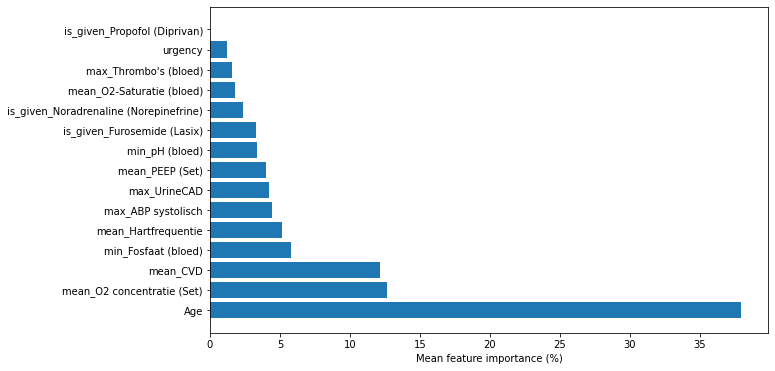

In [160]:
present=False

am_show_features = 60 if len(X_train.columns)>=30 else len(X_train.columns)
fi = CB_AF.feature_importances_
plt.figure(figsize=(10,6))
indices_T0 = np.argsort(fi)[::-1][0:am_show_features]
if present:
    plt.barh(range(am_show_features),fi[indices_T0],color="#e898ac")
else:
    plt.barh(range(am_show_features),fi[indices_T0])
plt.yticks(range(am_show_features), X_train.columns[indices_T0])
plt.xlabel("Mean feature importance (%)")
if present:
    ax = plt.gca()
    ax.patch.set_alpha(0)
#plt.tight_layout()
plt.show()

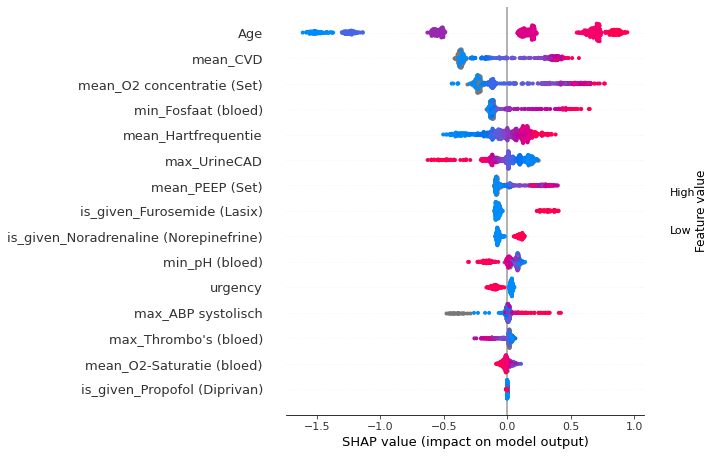

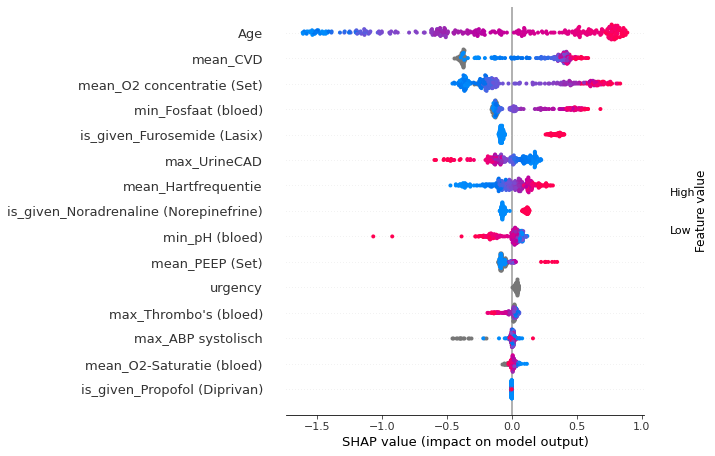

In [161]:
present=False

plt.figure()
explainer = shap.TreeExplainer(CB_AF)
shap_values = explainer.shap_values(X_test_amst)
shap.summary_plot(shap_values, X_test_amst,show=False)
plt.plot()
plt.figure()
explainer = shap.TreeExplainer(CB_AF)
shap_values = explainer.shap_values(X_test_uzgent)
shap.summary_plot(shap_values, X_test_uzgent,show=False)

## Direct validation

In [162]:
validation_type_string = "direct"

### Data Import

In [163]:
if one_half_hour_model:
        AF_dataset_uzgent = pd.read_csv(uzgent_data_path+"AF_dataset_1_5_hours.csv") 
        AF_dataset = pd.read_csv(amsterdam_data_path+"AF_dataset_1_5_hours.csv") 
elif six_hour_model:
        AF_dataset_uzgent = pd.read_csv(uzgent_data_path+"AF_dataset_6_hours.csv") 
        AF_dataset = pd.read_csv(amsterdam_data_path+"AF_dataset_6_hours.csv") 
else:
        AF_dataset_uzgent = pd.read_csv(uzgent_data_path+"AF_dataset_12_hours.csv") 
        AF_dataset = pd.read_csv(amsterdam_data_path+"AF_dataset_12_hours.csv") 

AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={"HospAdmissionID":"patientid","AgeOnAdmission":"Age","ICUSessionID":"admissionid"})
AF_dataset_uzgent.loc[AF_dataset_uzgent.sepsis_extra_opn_measuredat > AF_dataset_uzgent.AF_measuredat,"sepsis_bool_extra_opn"]=0

Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.


In [164]:
AF_dataset_uzgent["is_given_NORepinefrine"]=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_CV_norepinephrine']>0,"is_given_NORepinefrine"]=1

AF_dataset_uzgent["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
AF_dataset_uzgent.loc[(AF_dataset_uzgent["mean_VI_calcium carbonate"]>1)|(AF_dataset_uzgent["mean_VI_calcium chloride"]>1),"is_given_Calcium Glubionaat (Calcium Sandoz)"] = 1
    
AF_dataset_uzgent["is_given_Dopamine (Inotropin)"]=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_CV_dopamine']>0,"is_given_Dopamine (Inotropin)"]=1

AF_dataset_uzgent['is_given_Propofol (Diprivan)']=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_NS_propofol']>0,'is_given_Propofol (Diprivan)']=1

AF_dataset_uzgent['is_given_Fentanyl']=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_NS_fentanyl']>0,'is_given_Fentanyl']=1

AF_dataset_uzgent["is_given_Furosemide (Lasix)"]=0
AF_dataset_uzgent.loc[AF_dataset_uzgent['mean_DI_furosemide']>0,"is_given_Furosemide (Lasix)"]=1

AF_dataset_uzgent["is_given_LoopDiuretics"]=0
AF_dataset_uzgent.loc[(AF_dataset_uzgent['mean_DI_furosemide']>0),"is_given_LoopDiuretics"]=1

AF_dataset_uzgent["sepsis_bool"]=0
AF_dataset_uzgent.loc[(AF_dataset_uzgent.sepsis_bool_comorb_source==1) | (AF_dataset_uzgent.sepsis_bool_extra_opn==1),"sepsis_bool"]=1

AF_dataset_uzgent.loc[AF_dataset_uzgent.icuurg=="URGENT","icuurg"]=1
AF_dataset_uzgent.loc[AF_dataset_uzgent.icuurg!=1,"icuurg"]=0

In [165]:
AF_dataset["is_given_Magnesiumsulfaat (MgSO4)"]=0
AF_dataset.loc[AF_dataset['mean_Magnesiumsulfaat (MgSO4)']>0,"is_given_Magnesiumsulfaat (MgSO4)"]=1

AF_dataset["is_given_Calcium Glubionaat (Calcium Sandoz)"]=0
AF_dataset.loc[AF_dataset['mean_Calcium Glubionaat (Calcium Sandoz)']>0,"is_given_Calcium Glubionaat (Calcium Sandoz)"]=1

AF_dataset["is_given_LoopDiuretics"]=0
AF_dataset.loc[ (AF_dataset['mean_Furosemide (Lasix)']>0),"is_given_LoopDiuretics"]=1

AF_dataset['is_given_Propofol (Diprivan)']=0
AF_dataset.loc[AF_dataset['mean_Propofol (Diprivan)']>0,'is_given_Propofol (Diprivan)']=1

AF_dataset['is_given_Dopamine (Inotropin)']=0
AF_dataset.loc[AF_dataset['mean_Dopamine (Inotropin)']>0,'is_given_Dopamine (Inotropin)']=1

In [166]:
AF_dataset.loc[AF_dataset.Age==65,'Age'] = 69
AF_dataset.loc[AF_dataset.Age==35,'Age'] = 39
AF_dataset.loc[AF_dataset.Age==45,'Age'] = 49
AF_dataset.loc[AF_dataset.Age==55,'Age'] = 59
AF_dataset.loc[AF_dataset.Age==79,'Age'] = 79
AF_dataset.loc[AF_dataset.Age==85,'Age'] = 80

In [167]:
#Rename for distr change 12 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={'mean_PEEP_M_ALL':'mean_PEEP (Set)', 'is_given_NORepinefrine':'is_given_Noradrenaline (Norepinefrine)', 'mean_URINE_VOL':'mean_UrineCAD', 
                            'max_PEEP_M_ALL':'max_PEEP (Set)','min_PEEP_M_ALL':'min_PEEP (Set)',
                            'max_PHOSPHATE_ALL':'max_Fosfaat (bloed)','min_HR_ALL':'min_Hartfrequentie','mean_HR_ALL':'mean_Hartfrequentie','slope_HR_ALL':'slope_Hartfrequentie',
                            'min_PH_ART_ALL':'min_pH (bloed)','mean_PH_ART_ALL':'mean_pH (bloed)','max_PH_ART_ALL':'max_pH (bloed)',
                            'mean_LACTATE_ART':'mean_Lactaat (bloed)','max_LACTATE_ART':'max_Lactaat (bloed)' ,'min_LACTATE_ART':'min_Lactaat (bloed)' , 
                            'min_URINE_VOL':'min_UrineCAD', 'max_URINE_VOL':'max_UrineCAD', 'slope_URINE_VOL':'slope_UrineCAD', 'icuurg':'urgency',
                            'mean_BALANS-Tot.':'fluid_balance', 'slope_RESPRATE_ALL':'slope_O2 l/min','Length':'Height',
                            'mean_HCO3_ART':'mean_Act.HCO3 (bloed)','max_HCO3_ART':'max_Act.HCO3 (bloed)','min_HCO3_ART':'min_Act.HCO3 (bloed)','slope_HCO3_ART':'slope_Act.HCO3 (bloed)',
                            'mean_PO2_ART':'mean_PO2 (bloed)','min_PO2_ART':'min_PO2 (bloed)','max_PO2_ART':'max_PO2 (bloed)','slope_PO2_ART':'slope_PO2 (bloed)',
                            'mean_BE_ART':'mean_B.E. (bloed)','min_BE_ART':'min_B.E. (bloed)','max_BE_ART':'max_B.E. (bloed)','slope_BE_ART':'slope_B.E. (bloed)',
                            'mean_PCO2_ART':'mean_pCO2 (bloed)','min_PCO2_ART':'min_pCO2 (bloed)','max_PCO2_ART':'max_pCO2 (bloed)','slope_PCO2_ART':'slope_pCO2 (bloed)',
                            'mean_IBP_M':'mean_ABP gemiddeld','min_IBP_M':'min_ABP gemiddeld','max_IBP_M':'max_ABP gemiddeld','slope_IBP_M':'slope_ABP gemiddeld',
                            'mean_IBP_S':'mean_ABP systolisch','min_IBP_S':'min_ABP systolisch','max_IBP_S':'max_ABP systolisch','slope_IBP_S':'slope_ABP systolisch',
                            'mean_FIO2_MV_ALL':'mean_O2 concentratie (Set)','max_FIO2_MV_ALL':'max_O2 concentratie (Set)','min_FIO2_MV_ALL':'min_O2 concentratie (Set)',
                            'mean_O2SAT_ART':'mean_O2-Saturatie (bloed)','max_O2SAT_ART':'max_O2-Saturatie (bloed)','min_O2SAT_ART':'min_O2-Saturatie (bloed)',
                           'min_NS_propofol':'min_Propofol (Diprivan)', 'min_NS_fentanyl':'min_Fentanyl', 'mean_RESPRATE_ALL':'mean_O2 l/min', 
                           'mean_PHOSPHATE_ALL':'mean_Fosfaat (bloed)', 'kurt_CVD':'kurt_CVD', 'max_HR_ALL':'max_Hartfrequentie', "max_PLATELETS":"max_Thrombo's (bloed)"})

#Rename for distr change 6 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={'max_RESPRATE_ALL':'max_O2 l/min',
                                        'min_PHOSPHATE_ALL':'min_Fosfaat (bloed)', 'mean_CVD':'mean_CVD', 
                                        "min_PLATELETS":"min_Thrombo's (bloed)","slope_PLATELETS":"slope_Thrombo's (bloed)"})

#Rename for distr change 1.5 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={'max_UREA_ALL':'max_Ureum (bloed)','mean_UREA_ALL':'mean_Ureum (bloed)','min_UREA_ALL':'min_Ureum (bloed)'})

#Rename for standard 12 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={"slope_PO2_ART":'slope_PO2 (bloed)'})

#Rename for standard 1.5 hour model
AF_dataset_uzgent = AF_dataset_uzgent.rename(columns={ 'min_RESPRATE_ALL':'min_O2 l/min', "mean_PLATELETS":"mean_Thrombo's (bloed)",
                                        'min_CVD':'min_CVD'})

#convert from mg/dl to mmol/l
AF_dataset_uzgent.loc[:,"min_Ureum (bloed)"] = AF_dataset_uzgent["min_Ureum (bloed)"]*0.357
#convert from percentages to fraction
AF_dataset_uzgent.loc[:,"mean_O2-Saturatie (bloed)"] = AF_dataset_uzgent["mean_O2-Saturatie (bloed)"]/100.0
#convert from mg/dl to mmol/l
AF_dataset_uzgent.loc[:,"mean_Lactaat (bloed)"] = AF_dataset_uzgent["mean_Lactaat (bloed)"]/9.0

In [168]:
AF_1_df = AF_dataset[AF_dataset.AF==1]
AF_0_matched_df = AF_dataset[(AF_dataset.AF==0)&(AF_dataset.admissionid!=AF_dataset.date_corresponds_to_AF_admid)]

train_admissionid,test_admissionid = train_test_split(AF_1_df.admissionid.unique(), test_size=0.2, random_state=42)

train_AF_1_dataset = AF_1_df[AF_1_df.admissionid.isin(train_admissionid)]
test_AF_1_dataset = AF_1_df[AF_1_df.admissionid.isin(test_admissionid)]

train_AF_0_dataset = AF_0_matched_df[AF_0_matched_df.date_corresponds_to_AF_admid.isin(train_AF_1_dataset.admissionid)]
test_AF_0_dataset = AF_0_matched_df[AF_0_matched_df.date_corresponds_to_AF_admid.isin(test_AF_1_dataset.admissionid)]

train_AF_dataset = train_AF_0_dataset.append(train_AF_1_dataset).reset_index(drop=True).sample(len(train_AF_0_dataset)+len(train_AF_1_dataset),random_state=42)
test_AF_dataset_amst = test_AF_0_dataset.append(test_AF_1_dataset).reset_index(drop=True).sample(len(test_AF_0_dataset)+len(test_AF_1_dataset),random_state=42)

In [169]:
AF_1_df_uzgent = AF_dataset_uzgent[AF_dataset_uzgent.AF==1]
AF_0_matched_df_uzgent = AF_dataset_uzgent[(AF_dataset_uzgent.AF==0)&(AF_dataset_uzgent.admissionid!=AF_dataset_uzgent.date_corresponds_to_AF_admid)]

train_admissionid_uzgent,test_admissionid_uzgent = train_test_split(AF_1_df_uzgent.admissionid.unique(), test_size=0.2, random_state=42)

test_AF_1_dataset_uzgent = AF_1_df_uzgent[AF_1_df_uzgent.admissionid.isin(test_admissionid_uzgent)]
test_AF_0_dataset_uzgent = AF_0_matched_df_uzgent[AF_0_matched_df_uzgent.date_corresponds_to_AF_admid.isin(test_AF_1_dataset_uzgent.admissionid)]
test_AF_dataset = test_AF_0_dataset_uzgent.append(test_AF_1_dataset_uzgent).reset_index(drop=True).sample(len(test_AF_0_dataset_uzgent)+len(test_AF_1_dataset_uzgent),random_state=42)

In [170]:
uzgent_drop_columns = ['patientid', 'hadm_id', 'admittime', 'AF_measuredat', 'intime',
       'outtime', 'admissionid', 'lengthofstay']

drop_columns = ["dateofdeath_delta","admittedat_delta","admissionid","origin",
                "lengthofstay","destination","weightgroup","agegroup","dateofdeath",
                "admittedat","heightgroup","specialty","dateofdeath_delta","admittedat_delta","weightsource","dischargedat","heightsource",
                "gender","Mortality","AF_orig","AF_measuredat","AF","new_onset_AF","Preadmission_AF","patientid","location","admissionyeargroup"]

uzgent_drop_columns.append('date_corresponds_to_AF_admid')
drop_columns.append('date_corresponds_to_AF_admid')

In [171]:
X_train_or = train_AF_dataset
X_test_or = test_AF_dataset
y_train = train_AF_dataset.AF
y_test = test_AF_dataset.AF

X_test_or_amst = test_AF_dataset_amst
y_test_amst = test_AF_dataset_amst.AF

### Testing

In [172]:
if one_half_hour_model:

    feature_columns = ['Age', 
        'is_given_Noradrenaline (Norepinefrine)', 
        'max_Hartfrequentie',
       'mean_PEEP (Set)', 
       'mean_CVD', 
       'mean_O2 concentratie (Set)',
       "min_Thrombo's (bloed)",
       'urgency', 
       'mean_UrineCAD', 
       'is_given_Furosemide (Lasix)', 
       'mean_Ureum (bloed)',
       'slope_B.E. (bloed)',
       'slope_ABP systolisch', 
       'mean_O2-Saturatie (bloed)', 
       'fluid_balance']

elif six_hour_model:

    feature_columns = ['Age', 
        'is_given_Noradrenaline (Norepinefrine)',
        'max_Hartfrequentie', 
        'mean_PEEP (Set)',
        'min_CVD',
        'mean_O2 concentratie (Set)', 
        'urgency', 
        'mean_UrineCAD',
        'is_given_Furosemide (Lasix)', 
        'fluid_balance', 
        'slope_ABP gemiddeld',
        'mean_O2-Saturatie (bloed)', 
        'max_Fosfaat (bloed)',
        'max_ABP systolisch',
        'min_Lactaat (bloed)'
    ]

else:

    feature_columns = ['Age',
        'mean_CVD',
        'mean_O2 concentratie (Set)',
        'mean_PEEP (Set)',
        'is_given_Noradrenaline (Norepinefrine)',
        'min_pH (bloed)',
        'max_UrineCAD',
        'mean_Hartfrequentie',
        'urgency',
        'min_Fosfaat (bloed)',
        'is_given_Furosemide (Lasix)',
        'is_given_Propofol (Diprivan)',
        'mean_O2-Saturatie (bloed)',
        "max_Thrombo's (bloed)",
        'max_ABP systolisch'
    ]


X_train=X_train_or[feature_columns]    
X_test=X_test_or[feature_columns]   

X_test_amst = X_test_or_amst[feature_columns]

In [173]:
AF_class_balance = [y_train.sum()/len(y_train),1-y_train.sum()/len(y_train)]

if one_half_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, l2_leaf_reg=3, depth=3, class_weights=AF_class_balance)
elif six_hour_model:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=400, depth=3, l2_leaf_reg=3, class_weights=AF_class_balance)
else:
    CB_AF = CatBoostClassifier(
        verbose=100, iterations=300, depth=3, l2_leaf_reg=3, class_weights=AF_class_balance)


CB_AF.fit(X_train,y_train)

0:	learn: 0.6868328	total: 1.3ms	remaining: 390ms
100:	learn: 0.5484908	total: 111ms	remaining: 218ms
200:	learn: 0.5242838	total: 210ms	remaining: 103ms
299:	learn: 0.5086253	total: 314ms	remaining: 0us


In [174]:
print(classification_report(y_train,CB_AF.predict(X_train),target_names=["No-AF","AF"]))

              precision    recall  f1-score   support

       No-AF       0.76      0.74      0.75      1335
          AF       0.75      0.76      0.75      1335

    accuracy                           0.75      2670
   macro avg       0.75      0.75      0.75      2670
weighted avg       0.75      0.75      0.75      2670



In [175]:
print("BALANCED TEST PATIENTS")
print(classification_report(y_test,CB_AF.predict(X_test),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_AF.predict(X_test)),4)))
print(50*"=")

BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.71      0.68      0.69       157
          AF       0.69      0.73      0.71       158

    accuracy                           0.70       315
   macro avg       0.70      0.70      0.70       315
weighted avg       0.70      0.70      0.70       315



AUC = 0.746
MCC = 0.4036


In [176]:
direct_y_test = y_test
direct_predict = CB_AF.predict(X_test)
AMST_y_test = y_test_amst
AMST_predict = CB_AF.predict(X_test_amst)

In [177]:
temp_large_db = AF_dataset_uzgent[((AF_dataset_uzgent.AF==0)&(~AF_dataset_uzgent.admissionid.isin(AF_0_matched_df_uzgent.admissionid)))|(AF_dataset_uzgent.admissionid.isin(test_AF_dataset.admissionid))]

y_test_all_pat = temp_large_db.AF
X_test_all_pat = temp_large_db[feature_columns]


print("ALL PATIENTS")
print(classification_report(y_test_all_pat,CB_AF.predict(X_test_all_pat),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test_all_pat,label=y_test_all_pat), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test_all_pat,CB_AF.predict(X_test_all_pat)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("all patients",X_test_all_pat,y_test_all_pat,CB_AF,uzgent_result_dataframe)

print("BALANCED TEST PATIENTS")
print(classification_report(y_test,CB_AF.predict(X_test),target_names=["No-AF","AF"]))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_AF, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_AF.predict(X_test)),4)))
print(50*"=")

uzgent_result_dataframe = pandas_result_AF_maker("balanced test",X_test,y_test,CB_AF,uzgent_result_dataframe)

ALL PATIENTS
              precision    recall  f1-score   support

       No-AF       0.99      0.67      0.80      9835
          AF       0.03      0.73      0.07       158

    accuracy                           0.67      9993
   macro avg       0.51      0.70      0.43      9993
weighted avg       0.98      0.67      0.79      9993



AUC = 0.7687
MCC = 0.1061
ECE normalized AUC (%) = 5.84 %
ESCE normalized AUC (%) = -3.98 %
BALANCED TEST PATIENTS
              precision    recall  f1-score   support

       No-AF       0.71      0.68      0.69       157
          AF       0.69      0.73      0.71       158

    accuracy                           0.70       315
   macro avg       0.70      0.70      0.70       315
weighted avg       0.70      0.70      0.70       315



AUC = 0.746
MCC = 0.4036
ECE normalized AUC (%) = 14.0 %
ESCE normalized AUC (%) = 5.35 %


<Figure size 432x288 with 0 Axes>

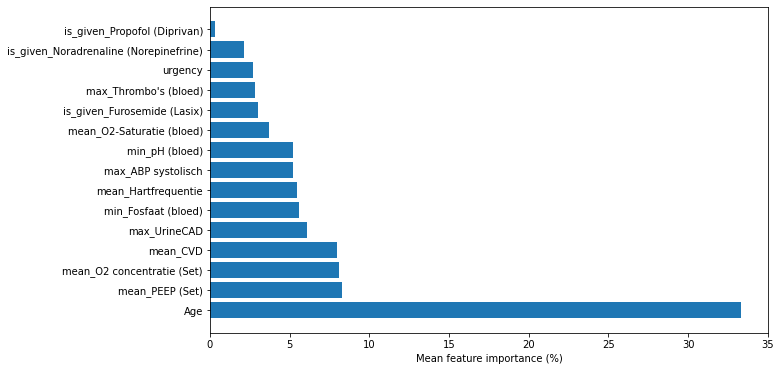

In [178]:
present=False

am_show_features = 60 if len(X_train.columns)>=30 else len(X_train.columns)
fi = CB_AF.feature_importances_
plt.figure(figsize=(10,6))
indices_T0 = np.argsort(fi)[::-1][0:am_show_features]
if present:
    plt.barh(range(am_show_features),fi[indices_T0],color="#e898ac")
else:
    plt.barh(range(am_show_features),fi[indices_T0])
plt.yticks(range(am_show_features), X_train.columns[indices_T0])
plt.xlabel("Mean feature importance (%)")
if present:
    ax = plt.gca()
    ax.patch.set_alpha(0)
plt.show()

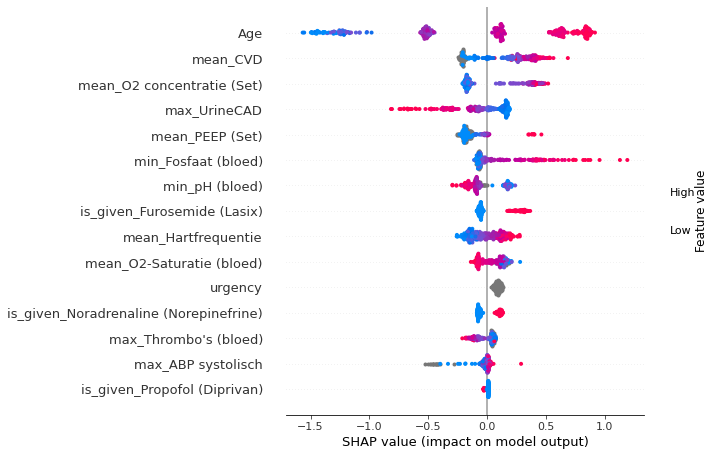

In [179]:
present=False

explainer = shap.TreeExplainer(CB_AF)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test,show=False)


In [180]:
uzgent_result_dataframe

,model,validation_type,patient_group,NO AF patients,AF patients,NO AF recall,AF recall,NO AF precision,AF precision,NO AF f1,AF f1,mcc,auc,ECE,ESCE
0,1.5,transfer,balanced test,182,183,0.741758,0.836066,0.818182,0.765000,0.778098,0.798956,0.580497,0.851889,0.093160,0.073044
0,1.5,transfer,all patients,19244,183,0.735190,0.836066,0.997884,0.029148,0.846628,0.056333,0.124268,0.849723,0.043709,-0.036589
0,1.5,combo,all patients uzgent,19244,183,0.709312,0.830601,0.997734,0.026453,0.829157,0.051273,0.114276,0.844137,0.043521,-0.031597
0,1.5,combo,balanced test uzgent,182,183,0.708791,0.830601,0.806250,0.741463,0.754386,0.783505,0.543537,0.833964,0.102046,0.079551
0,1.5,combo,all patients amsterdam,14563,400,0.733983,0.702500,0.988990,0.067629,0.842616,0.123381,0.157204,0.798620,0.022080,0.018473
0,1.5,combo,balanced test amsterdam,400,400,0.745000,0.702500,0.714628,0.733681,0.729498,0.717752,0.447905,0.809369,0.059303,0.018051
0,1.5,direct,all patients,19244,183,0.571191,0.912568,0.998547,0.019836,0.726696,0.038828,0.094301,0.835052,0.147671,-0.146993
0,1.5,direct,balanced test,182,183,0.565934,0.912568,0.865546,0.678862,0.684385,0.778555,0.510393,0.831952,0.081436,0.035613
0,6,transfer,balanced test,158,158,0.746835,0.841772,0.825175,0.768786,0.784053,0.803625,0.591278,0.876662,0.104162,0.081829
0,6,transfer,all patients,12241,158,0.750511,0.841772,0.997286,0.041732,0.856477,0.079522,0.152019,0.866587,0.039773,-0.031281


In [ ]:
# uzgent_result_dataframe.to_csv("../results/uzgent_result_dataframe.csv",index=False)

# P-tests

In [ ]:
#bonferri correction: alpha/m, with m the amount of total tests
from scipy.stats import ranksums

# print("p-value comparisons")
# print(100*"=")
# print("")
    

# print("Direct - Internal")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(direct_predict,AMST_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(direct_predict[np.where(direct_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(direct_predict[np.where(direct_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]))
# print(40*"=")
# print("")
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Direct - Internal","all",ranksums(direct_predict,AMST_predict)[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Direct - Internal","AF",ranksums(direct_predict[np.where(direct_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Direct - Internal","NO AF",ranksums(direct_predict[np.where(direct_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])


# print("Combo uzgent - Internal ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict,AMST_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]))
# print(40*"=")
# print("")
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo uzgent - Internal","all",ranksums(combo_uzgent_predict,AMST_predict)[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo uzgent - Internal","AF",ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo uzgent - Internal","NO AF",ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])


# print("Combo amst - Internal ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(combo_amst_predict,AMST_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(combo_amst_predict[np.where(combo_amst_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(combo_amst_predict[np.where(combo_amst_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]))
# print(40*"=")
# print("")
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo amst - Internal","all",ranksums(combo_amst_predict,AMST_predict)[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo amst - Internal","AF",ranksums(combo_amst_predict[np.where(combo_amst_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo amst - Internal","NO AF",ranksums(combo_amst_predict[np.where(combo_amst_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])


# print("Transfer - Internal ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict,AMST_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]))
# print(40*"=")
# print("")
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Internal","all",ranksums(transfer_predict,AMST_predict)[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Internal","AF",ranksums(transfer_predict[np.where(transfer_y_test==1)],AMST_predict[np.where(AMST_y_test==1)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Internal","NO AF",ranksums(transfer_predict[np.where(transfer_y_test==0)],AMST_predict[np.where(AMST_y_test==0)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])


# print("Transfer - Combo uzgent ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict,combo_uzgent_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==1)],combo_uzgent_predict[np.where(combo_uzgent_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==0)],combo_uzgent_predict[np.where(combo_uzgent_y_test==0)])[1]))
# print(40*"=")
# print("")
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Combo uzgent","all",ranksums(transfer_predict,combo_uzgent_predict)[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Combo uzgent","AF",ranksums(transfer_predict[np.where(transfer_y_test==1)],combo_uzgent_predict[np.where(combo_uzgent_y_test==1)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Combo uzgent","NO AF",ranksums(transfer_predict[np.where(transfer_y_test==0)],combo_uzgent_predict[np.where(combo_uzgent_y_test==0)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])


# print("Transfer - Direct ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict,direct_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==1)],direct_predict[np.where(direct_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(transfer_predict[np.where(transfer_y_test==0)],direct_predict[np.where(direct_y_test==0)])[1]))
# print(40*"=")
# print("")
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Direct","all",ranksums(transfer_predict,direct_predict)[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Direct","AF",ranksums(transfer_predict[np.where(transfer_y_test==1)],direct_predict[np.where(direct_y_test==1)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Transfer - Direct","NO AF",ranksums(transfer_predict[np.where(transfer_y_test==0)],direct_predict[np.where(direct_y_test==0)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])


# print("Combo uzgent - Direct ")
# print("")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict,direct_predict)[1]))
# print(10*"-")
# print("AF ")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==1)],direct_predict[np.where(direct_y_test==1)])[1]))
# print(10*"-")
# print("NO AF")
# print("Rank-sum p-value: "+ str(ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==0)],direct_predict[np.where(direct_y_test==0)])[1]))
# print(40*"=")
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo uzgent - Direct","all",ranksums(combo_uzgent_predict,direct_predict)[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo uzgent - Direct","AF",ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==1)],direct_predict[np.where(direct_y_test==1)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])
uzgent_p_value_result_dataframe = pd.concat([uzgent_p_value_result_dataframe,pd.DataFrame(data=[[model_string,"Combo uzgent - Direct","NO AF",ranksums(combo_uzgent_predict[np.where(combo_uzgent_y_test==0)],direct_predict[np.where(direct_y_test==0)])[1]]],columns=uzgent_p_value_result_dataframe_columns)])



In [198]:
# uzgent_p_value_result_dataframe.to_csv("../results/uzgent_p_value_result_dataframe.csv",index=False)

# Data description

In [32]:
rename_dict = {'mean_Lactaat (bloed)':'Mean lactate (mmol/L)',
'slope_Hartfrequentie':'Slope heart frequency (bpm)',
'max_Hartfrequentie':'Max heart frequency (bpm)',
'mean_UrineCAD':'Mean hourly urinary volume (mL/h)',
'min_UrineCAD':'Min hourly urinary volume (mL/h)',
'mean_O2-Saturatie (bloed)':'Mean calculated O2 saturation on ABG (%)',
'max_PO2 (bloed)':'Max ABG partial oxygen pressure (mmHg)',
'mean_O2 concentratie (Set)':'Mean ventilator administered FiO2 (%)',
'urgency':'ICU admission Urgency',
"min_Thrombo's (bloed)":'Min thrombocytes (10³/µL)',
'is_given_Noradrenaline (Norepinefrine)':'Has received noradrenalin',
'min_Ureum (bloed)':'Min blood ureum (mmol/L)',
'mean_Ureum (bloed)':'Mean blood ureum (mmol/L)',
'is_given_Furosemide (Lasix)':'Has received loop diuretics',
'min_Act.HCO3 (bloed)':'Min bicarbonate (mmol/L',
'mean_Act.HCO3 (bloed)':'Mean bicarbonate (mmol/L',
'Weight':'Weight (kg)',
'mean_PEEP (Set)':'Mean PEEP setting (mmHg)',
'fluid_balance':'Fluid Balance (mL)',
'mean_CVD':'Mean CVP (mmHg)',
'min_CVD':'Min CVP (mmHg)',
'max_CVD':'Man CVP (mmHg)',
'slope_ABP systolisch':'Slope systolic ABP (mmHg)',
'min_ABP systolisch':'Min systolic ABP (mmHg)',
'min_pH (bloed)':'Min arterial pH on blood gas',
'slope_ABP gemiddeld':'Slope mean ABP (mmHg)',
'min_ABP gemiddeld':'Min mean ABP (mmHg)',
'max_Fosfaat (bloed)':'Max Phosphate (mmol/L)',
'max_ABP systolisch':'Max systolic ABP (mmHg)',
'min_Lactaat (bloed)':'Min Lactate (mmol/L)',
'max_UrineCAD':'Max hourly urinary volume (mL/h)',
'mean_Hartfrequentie':'Mean heart frequency (bpm)',
'min_Fosfaat (bloed)':'Min Phosphate (mmol/L)',
'is_given_Propofol (Diprivan)':'Has received Propofol (Diprivan)',
"max_Thrombo's (bloed)":'Max thrombocytes (10³/µL)',
'slope_B.E. (bloed)':'Slope base excess (mmol/L)'}

X_train_descr = X_train.rename(columns=rename_dict)
X_train_descr["ICU admission Urgency"] = X_train_descr["ICU admission Urgency"].astype(np.int32)


if one_half_hour_model:
    describe_df_15_no_AF = X_train_descr[y_train==0].describe().loc[['mean','25%','75%']].transpose().round(2)
    describe_df_15_no_AF["text"]=describe_df_15_no_AF["mean"].astype(str) +' ('+describe_df_15_no_AF["25%"].astype(str) +" - " + describe_df_15_no_AF["75%"].astype(str) + ")"
    describe_df_15_no_AF = describe_df_15_no_AF[["text"]]
    describe_df_15_no_AF = describe_df_15_no_AF.rename(columns={"text":"Model-1.5"})
    describe_df_15_no_AF = describe_df_15_no_AF.rename_axis('Feature').reset_index()

    describe_df_15_AF = X_train_descr[y_train==1].describe().loc[['mean','25%','75%']].transpose().round(2)
    describe_df_15_AF["text"]=describe_df_15_AF["mean"].astype(str) +' ('+describe_df_15_AF["25%"].astype(str) +" - " + describe_df_15_AF["75%"].astype(str) + ")"
    describe_df_15_AF = describe_df_15_AF[["text"]]
    describe_df_15_AF = describe_df_15_AF.rename(columns={"text":"Model-1.5"})
    describe_df_15_AF = describe_df_15_AF.rename_axis('Feature').reset_index()

    nans_15_AF_df = pd.DataFrame((X_train_descr[y_train==0].isna().mean()*100).round(2),columns=["Model-1.5_AF"]).rename_axis('Feature').reset_index()
    nans_15_noAF_df = pd.DataFrame((X_train_descr[y_train==1].isna().mean()*100).round(2),columns=["Model-1.5_noAF"]).rename_axis('Feature').reset_index()

    nans_15_df = nans_15_AF_df.copy(deep=True)
    nans_15_df["Model-1.5"] = nans_15_noAF_df["Model-1.5_noAF"].astype(str) + " - " +nans_15_AF_df["Model-1.5_AF"].astype(str)
    nans_15_df = nans_15_df[["Feature","Model-1.5"]]
    
    
elif six_hour_model:
    describe_df_6_no_AF = X_train_descr[y_train==0].describe().loc[['mean','25%','75%']].transpose().round(2)
    describe_df_6_no_AF["text"]=describe_df_6_no_AF["mean"].astype(str) +' ('+describe_df_6_no_AF["25%"].astype(str) +" - " + describe_df_6_no_AF["75%"].astype(str) + ")"
    describe_df_6_no_AF = describe_df_6_no_AF[["text"]]
    describe_df_6_no_AF = describe_df_6_no_AF.rename(columns={"text":"Model-6"})
    describe_df_6_no_AF = describe_df_6_no_AF.rename_axis('Feature').reset_index()

    describe_df_6_AF = X_train_descr[y_train==1].describe().loc[['mean','25%','75%']].transpose().round(2)
    describe_df_6_AF["text"]=describe_df_6_AF["mean"].astype(str) +' ('+describe_df_6_AF["25%"].astype(str) +" - " + describe_df_6_AF["75%"].astype(str) + ")"
    describe_df_6_AF = describe_df_6_AF[["text"]]
    describe_df_6_AF = describe_df_6_AF.rename(columns={"text":"Model-6"})
    describe_df_6_AF = describe_df_6_AF.rename_axis('Feature').reset_index()

    nans_6_AF_df = pd.DataFrame((X_train_descr[y_train==0].isna().mean()*100).round(2),columns=["Model-6_AF"]).rename_axis('Feature').reset_index()
    nans_6_noAF_df = pd.DataFrame((X_train_descr[y_train==1].isna().mean()*100).round(2),columns=["Model-6_noAF"]).rename_axis('Feature').reset_index()

    nans_6_df = nans_6_AF_df.copy(deep=True)
    nans_6_df["Model-6"] = nans_6_noAF_df["Model-6_noAF"].astype(str) + " - " +nans_6_AF_df["Model-6_AF"].astype(str)
    nans_6_df = nans_6_df[["Feature","Model-6"]]

else:
    describe_df_12_no_AF = X_train_descr[y_train==0].describe().loc[['mean','25%','75%']].transpose().round(2)
    describe_df_12_no_AF["text"]=describe_df_12_no_AF["mean"].astype(str) +' ('+describe_df_12_no_AF["25%"].astype(str) +" - " + describe_df_12_no_AF["75%"].astype(str) + ")"
    describe_df_12_no_AF = describe_df_12_no_AF[["text"]]
    describe_df_12_no_AF = describe_df_12_no_AF.rename(columns={"text":"Model-12"})
    describe_df_12_no_AF = describe_df_12_no_AF.rename_axis('Feature').reset_index()

    describe_df_12_AF = X_train_descr[y_train==1].describe().loc[['mean','25%','75%']].transpose().round(2)
    describe_df_12_AF["text"]=describe_df_12_AF["mean"].astype(str) +' ('+describe_df_12_AF["25%"].astype(str) +" - " + describe_df_12_AF["75%"].astype(str) + ")"
    describe_df_12_AF = describe_df_12_AF[["text"]]
    describe_df_12_AF = describe_df_12_AF.rename(columns={"text":"Model-12"})
    describe_df_12_AF = describe_df_12_AF.rename_axis('Feature').reset_index()

    nans_12_AF_df = pd.DataFrame((X_train_descr[y_train==0].isna().mean()*100).round(2),columns=["Model-12_AF"]).rename_axis('Feature').reset_index()
    nans_12_noAF_df = pd.DataFrame((X_train_descr[y_train==1].isna().mean()*100).round(2),columns=["Model-12_noAF"]).rename_axis('Feature').reset_index()

    nans_12_df = nans_12_AF_df.copy(deep=True)
    nans_12_df["Model-12"] = nans_12_noAF_df["Model-12_noAF"].astype(str) + " - " +nans_12_AF_df["Model-12_AF"].astype(str)
    nans_12_df = nans_12_df[["Feature","Model-12"]]


In [34]:
if len(describe_df_15_no_AF)*len(describe_df_6_no_AF)*len(describe_df_12_no_AF)>0:
    describe_df_15_AF.merge(describe_df_6_AF,on="Feature",how="outer").merge(describe_df_12_AF,on="Feature",how="outer").to_csv("../results/features_descriptions_AF_uzgent.csv",index=False)
    describe_df_15_no_AF.merge(describe_df_6_no_AF,on="Feature",how="outer").merge(describe_df_12_no_AF,on="Feature",how="outer").to_csv("../results/features_descriptions_no_AF_uzgent.csv",index=False)

In [33]:
if len(nans_15_df)*len(nans_6_df)*len(nans_12_df)>0:
    nans_15_df.merge(nans_6_df,on="Feature",how="outer").merge(nans_12_df,on="Feature",how="outer").to_csv("../results/nans_GUH.csv",index=False)

# Patient Demographics GUH

In [ ]:
#227428 SOFA mimic
#226743 	APACHE II 	

#13081 numeric items amst (apache II)

In [ ]:
admissions_pd_uzgent = pd.read_csv(r"Data/uzgent/uzgent-iv-1.0/df_adm_icu.csv",sep=',')
admissions_pd_uzgent = admissions_pd_uzgent.rename(columns={"subject_id":"patientid","stay_id":"admissionid","los":"lengthofstay"})
admissions_pd_uzgent.loc[:,"intime"] = pd.to_datetime(admissions_pd_uzgent.intime)
admissions_pd_uzgent.loc[:,"outtime"] = pd.to_datetime(admissions_pd_uzgent.outtime)
admissions_pd_uzgent.loc[:,"lengthofstay"]=admissions_pd_uzgent.lengthofstay*24
admissions_pd_uzgent.loc[admissions_pd_uzgent.AF_measuredat=="0","AF_measuredat"]=0.0
admissions_pd_uzgent.loc[admissions_pd_uzgent.AF_measuredat!=0,"AF_measuredat"]=(pd.to_datetime(admissions_pd_uzgent[admissions_pd_uzgent.AF_measuredat!=0].AF_measuredat)-pd.to_datetime(admissions_pd_uzgent[admissions_pd_uzgent.AF_measuredat!=0].intime)).dt.total_seconds()/60/60
admissions_pd_uzgent["AF_measuredat"] = np.float32(admissions_pd_uzgent["AF_measuredat"])
admissions_pd_uzgent = admissions_pd_uzgent[admissions_pd_uzgent.lengthofstay>=12]

weight_csv = pd.read_csv("Data/uzgent/uzgent-iv-1.0/icu/csv/chartevents/"+str(226512)+".csv")[["stay_id","valuenum"]]
weight_csv = weight_csv.rename(columns={"subject_id":"patientid","stay_id":"admissionid","valuenum":"weight"})
height_csv = pd.read_csv("Data/uzgent/uzgent-iv-1.0/icu/csv/chartevents/"+str(226730)+".csv")[["stay_id","valuenum"]]
height_csv = height_csv.rename(columns={"subject_id":"patientid","stay_id":"admissionid","valuenum":"height"})


admissions_pd_uzgent = admissions_pd_uzgent.merge(height_csv,how='left',on='admissionid')
admissions_pd_uzgent.loc[(admissions_pd_uzgent.height<50)|(admissions_pd_uzgent.height>250)]=int(admissions_pd_uzgent[(admissions_pd_uzgent.height<50)|(admissions_pd_uzgent.height>250)].height.mean())
admissions_pd_uzgent = admissions_pd_uzgent.merge(weight_csv,how='left',on='admissionid')
admissions_pd_uzgent.loc[(admissions_pd_uzgent.weight<20)|(admissions_pd_uzgent.weight>500)]=int(admissions_pd_uzgent[(admissions_pd_uzgent.weight<20)|(admissions_pd_uzgent.weight>500)].weight.mean())
admissions_pd_uzgent["BMI"]=admissions_pd_uzgent.weight/((admissions_pd_uzgent.height/100)**2)
    
df_patients = pd.read_csv(r"Data/uzgent/uzgent-iv-1.0/core/csv/patients.csv",sep=',')
df_patients = df_patients.rename(columns={"subject_id":"patientid","anchor_age":"Age"})

admissions_pd_uzgent = admissions_pd_uzgent.merge(df_patients[['patientid','Age','gender']],how='left',on='patientid')
#If no gender was specified, the value is -1.
gender_category = {'M':1,"F":0,"":-1}

#Replace the strings with numbers
admissions_pd_uzgent["gender"]=admissions_pd_uzgent["gender"].replace(gender_category)

admissions_pd_uzgent = admissions_pd_uzgent[(admissions_pd_uzgent.AF==0)|((admissions_pd_uzgent.AF==1)&(admissions_pd_uzgent.AF_measuredat>=12))]

print(len(admissions_pd_uzgent.patientid.unique()))

In [ ]:
sofa_uzgent_csv = pd.read_csv("Data/uzgent/uzgent-iv-1.0/uzgent_sofa.csv")[["stay_id","sofa_24hours","starttime","endtime"]]
sofa_uzgent_csv = sofa_uzgent_csv.rename(columns={"stay_id":"admissionid","sofa_24hours":"sofa"})
sofa_uzgent_csv.loc[:,"starttime"]=pd.to_datetime(sofa_uzgent_csv.starttime)
sofa_uzgent_csv.loc[:,"endtime"]=pd.to_datetime(sofa_uzgent_csv.endtime)
sofa_uzgent_csv = sofa_uzgent_csv.merge(admissions_pd_uzgent[["admissionid","patientid","intime","outtime","AF_measuredat","AF"]],how="inner",on="admissionid")
sofa_uzgent_csv["time_to_adm"] = (pd.to_datetime(sofa_uzgent_csv.starttime)-pd.to_datetime(sofa_uzgent_csv.intime)).dt.total_seconds()/60/60
sofa_mean_day_uzgent = sofa_uzgent_csv[sofa_uzgent_csv.time_to_adm<=24][["patientid","admissionid","sofa"]].groupby(["patientid","admissionid"]).mean().reset_index()
sofa_mean_day_uzgent = sofa_mean_day_uzgent.rename(columns={"sofa":"sofa_first24h"})
sofa_AF_uzgent = sofa_uzgent_csv[(sofa_uzgent_csv.AF==1)&(sofa_uzgent_csv.AF_measuredat - sofa_uzgent_csv.time_to_adm <= 1)&(sofa_uzgent_csv.AF_measuredat - sofa_uzgent_csv.time_to_adm >= 0)][["patientid","admissionid","sofa"]].groupby(["patientid","admissionid"]).mean().reset_index()
sofa_AF_uzgent = sofa_AF_uzgent.rename(columns={"sofa":"sofa_AF_matched"})
admissions_pd_uzgent = admissions_pd_uzgent.merge(sofa_mean_day_uzgent,how='left',on=['patientid','admissionid'])
admissions_pd_uzgent = admissions_pd_uzgent.merge(sofa_AF_uzgent,how='left',on=['patientid','admissionid'])

In [ ]:
admissions_pd_amst = pd.read_csv("Data/Extracted/admissions_demographics.csv")
admissions_pd_amst = admissions_pd_amst[admissions_pd_amst.lengthofstay>=12]
admissions_pd_amst.loc[admissions_pd_amst.Weight==0] = admissions_pd_amst[admissions_pd_amst.Weight>0].Weight.mean()
admissions_pd_amst.loc[admissions_pd_amst.Height==0] = admissions_pd_amst[admissions_pd_amst.Height>0].Height.mean()
admissions_pd_amst["BMI"]=admissions_pd_amst.Weight/((admissions_pd_amst.Height/100)**2)
admissions_pd_amst["AF_measuredat"] = admissions_pd_amst["AF_measuredat"]/1000/60/60
admissions_pd_amst = admissions_pd_amst[(admissions_pd_amst.AF==0)|((admissions_pd_amst.AF==1)&(admissions_pd_amst.AF_measuredat>=12))]

print(len(admissions_pd_amst.patientid.unique()))

amst_sofa = pd.read_csv(r"Data/sofa.csv",sep=',')
amst_apache_II = pd.read_csv(r"Data/apache_ii.csv",sep=',')
admissions_pd_amst = admissions_pd_amst.merge(amst_sofa[["admissionid","sofa_total_score"]],how='left',on='admissionid')
admissions_pd_amst = admissions_pd_amst.merge(amst_apache_II[["admissionid","apache_ii_total_score"]],how='left',on='admissionid')

In [ ]:
print(len(admissions_pd_uzgent.patientid.unique()))
print(len(admissions_pd_amst.patientid.unique()))
print(len(admissions_pd_uzgent[admissions_pd_uzgent.AF==1].patientid.unique()))
print(len(admissions_pd_amst[admissions_pd_amst.AF==1].patientid.unique()))
print(len(admissions_pd_uzgent[admissions_pd_uzgent.AF==0].patientid.unique()))
print(len(admissions_pd_amst[admissions_pd_amst.AF==0].patientid.unique()))

In [ ]:
print("AMSTERDAM COLUMNS")
print("")
print(admissions_pd_amst.columns)
print(50*"-")
print("")
print("UZGENT COLUMNS")
print("")
print(admissions_pd_uzgent.columns)

In [ ]:
admissions_pd_uzgent[admissions_pd_uzgent.AF==1].admission_type.value_counts()

In [ ]:
(1292+623)/len(admissions_pd_uzgent[admissions_pd_uzgent.AF==1])*100

In [ ]:
admissions_pd_amst[admissions_pd_amst.AF==0].specialty.value_counts()

In [ ]:
(6172+2092+1019+32)/len(admissions_pd_amst[admissions_pd_amst.AF==0])*100

In [ ]:
admissions_pd_uzgent.admission_type.value_counts()

In [ ]:
admissions_pd_uzgent[admissions_pd_uzgent.AF>=0].drop_duplicates("patientid").ethnicity.value_counts()

In [ ]:
print(admissions_pd_amst[admissions_pd_amst.AF==0].cardio_surgery_new.sum())
print(admissions_pd_amst[admissions_pd_amst.AF==0].sepsis_bool.sum())
admissions_pd_amst[admissions_pd_amst.AF==0].drop_duplicates("patientid").describe()

In [ ]:
print(admissions_pd_uzgent[admissions_pd_uzgent.AF==0].cardiac_bool_new.sum())
print(admissions_pd_uzgent[admissions_pd_uzgent.AF==0].sepsis_bool.sum())
admissions_pd_uzgent[admissions_pd_uzgent.AF==0].drop_duplicates("patientid").describe()

In [ ]:
5165*0.692352

In [ ]:
admissions_pd_uzgent.AF_measuredat

In [ ]:
1-0.519807

In [ ]:
1868*0.480193

In [ ]:
from scipy import stats

stats.ttest_ind(admissions_pd_amst[admissions_pd_amst.AF==0].sofa_total_score, admissions_pd_uzgent[(admissions_pd_uzgent.AF==0)&(~admissions_pd_uzgent.sofa_first24h.isna())].sofa_first24h)

In [ ]:
stats.ranksums(admissions_pd_amst[admissions_pd_amst.AF==0].Gender_category, admissions_pd_uzgent[admissions_pd_uzgent.AF==0].gender)